In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor, tensor, long
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential, functional)
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import random
import os

# constants
DATASET_DIR = 'data/'
WIDTH, HEIGHT = 32, 32    
DIMS = (WIDTH, HEIGHT)
CHANNELS = 3

In [2]:
# load the dataset using certain transforms
transformations = transforms.Compose([transforms.Resize(DIMS), transforms.ToTensor()])
dataset = ImageFolder(DATASET_DIR, transform = transformations)
CLASSES = dataset.class_to_idx.keys()
NUM_CLASSES = len(CLASSES)

Image sampled from class "clothes"


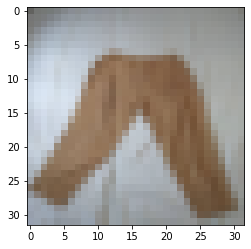

In [3]:
# show a random sample image alongside its class label
random_img_idx = np.random.choice(len(dataset))
random_img = dataset[random_img_idx]
plt.imshow(random_img[0].permute(1, 2, 0)) # need to permute to put channels at end of tuple
print(f'Image sampled from class "{dataset.classes[random_img[1]]}"')

Total length of dataset: 15515


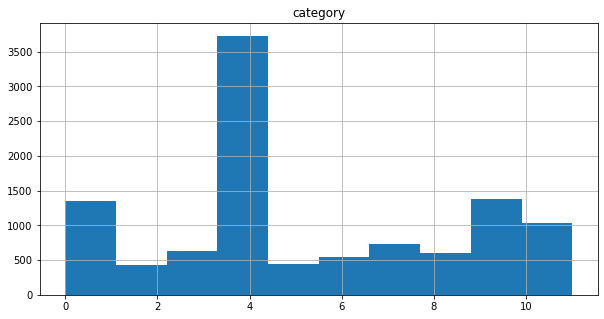

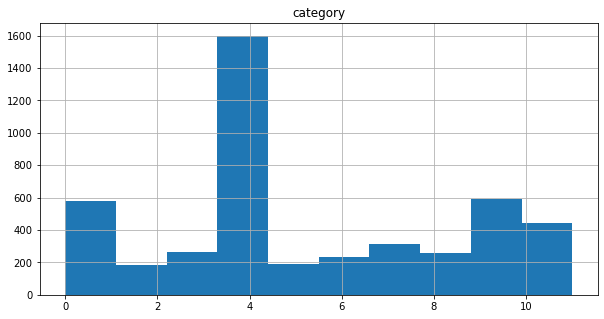

In [4]:
dataset_len = len(dataset)
dataset_df = pd.DataFrame(dataset.samples, columns=['img_path','category'])
print(f'Total length of dataset: {dataset_len}')
TRAIN, TEST = train_test_split(dataset_df, test_size=0.3, stratify=dataset_df[['category']], random_state=0)
TRAIN.hist(column='category', label=dataset.class_to_idx.keys(), figsize=(10,5))
TEST.hist(column='category', figsize=(10,5));

In [5]:
class GarbageDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize(DIMS),
            ToTensor()
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['img_path']).convert('RGB')
        return {
          'image': self.transformations(image),
          'category': tensor([row['category']], dtype=long),
          'path': row['img_path']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [6]:
def prepare_data(train_df) -> None:
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        validate_folds = []
        for train_index, validate_index in skf.split(train_df, train_df['category']):
            train_folds.append(GarbageDataset(train_df.iloc[train_index]))
            validate_folds.append(GarbageDataset(train_df.iloc[validate_index]))
        return [
            train_folds,
            validate_folds,
        ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)

train_folds, validate_folds = prepare_data(TRAIN)

In [7]:
class GarbageDetectorCNN(nn.Module):
    def __init__(self):
        super(GarbageDetectorCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, NUM_CLASSES)
    
    def forward(self, x: Tensor):
        """ forward pass
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

garbage_detector_model = GarbageDetectorCNN()

In [8]:
#@title Hyperparameters
epochs = 10 #@param {type:"slider", min:10, max:100, step:1}
learning_rate = 0.001 #@param {type:"number"}
retrain = False

"""
Training Step
"""

import warnings
warnings.filterwarnings('ignore')

LOSS_FN = CrossEntropyLoss()

def train_model(train_fold):
    optimizer = Adam(garbage_detector_model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['category']
            labels = labels.flatten()
            outputs = garbage_detector_model(inputs)
            loss = LOSS_FN(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print(f'Training Loss (after epoch {epoch}):', loss_train)

In [9]:
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def evaluate_model(validate_fold):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_fold)):
        inputs, targets = data['image'], data['category']
        targets = targets.flatten()
        output = garbage_detector_model(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    # return metrics
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),
            accuracy_score(actuals, predictions),
            *precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

In [10]:
"""
Run k-fold training/validation
"""
fold_results = []
fold_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))

for fold_index in range(len(train_folds)):
    train_model(train_folds[fold_index])
    fold_result = evaluate_model(validate_folds[fold_index])
    # conf_mat, acc, pre, recall, f-score
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if fold_index != len(train_dfs)-1:
        garbage_detector_model = GarbageDetectorCNN()
    
metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
plot_cm(fold_confusion_matrix, CLASSES)

Training Loss (after epoch 0): tensor(560.7532, grad_fn=<AddBackward0>)
Training Loss (after epoch 1): tensor(412.7900, grad_fn=<AddBackward0>)


KeyboardInterrupt: 